In [20]:
import os
import cv2
import time
import random
import numpy as np
from mtcnn.mtcnn import MTCNN

import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import backend, layers, metrics
from tensorflow.keras import layers, Model
from keras.layers import Input, Flatten, Dense, BatchNormalization, Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras_facenet import FaceNet
#from pydotplus import InvocationException

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__


('2.10.0', '1.26.4')

In [21]:
# Check available physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

GPU memory growth enabled


crop face

In [22]:

# # Function to detect faces and crop images
# def detect_and_crop(image_path, output_folder):
#     # Load image
#     image = cv2.imread(image_path)

#     # Convert to RGB (MTCNN requires RGB format)
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Detect faces
#     detector = MTCNN()
#     faces = detector.detect_faces(image_rgb)

#     # Crop and save faces
#     for i, face_info in enumerate(faces):
#         x, y, width, height = face_info['box']
#         # x=x+int(-0.2*x)
#         # y=y+int(-0.6*y)
#         # width=width+int(0.6*width)
#         # height=height+int(0.6*height)
#         face = image[y:y+height, x:x+width]
#         output_path = os.path.join(output_folder, f"face_{i+1}_{os.path.basename(image_path)}")
#         cv2.imwrite(output_path, face)

# # Main function to process all images in a directory
        
# def process_images_in_directory(input_folder, output_folder):
#     # Loop through subdirectories in the input folder
#     for subdir, _, files in os.walk(input_folder):
#         # Skip the root directory
#         if subdir == input_folder:
#             continue

#         # Create corresponding subdirectory in the output folder
#         relative_path = os.path.relpath(subdir, input_folder)
#         output_subdirectory = os.path.join(output_folder, relative_path)
#         os.makedirs(output_subdirectory, exist_ok=True)

#         # Process images in the current subdirectory
#         for file in files:
#             # Check if the file is an image (you can add more extensions if needed)
#             if file.lower().endswith(('.png', '.jpg', '.jpeg')):
#                 image_path = os.path.join(subdir, file)
#                 detect_and_crop(image_path, output_subdirectory)

# # Replace 'traindataset' and 'output_folder' with your actual folder names
# input_folder = r'C:\Users\bista\project\BCTMINORPROJECT\Mainfolder\dataset\person'
# output_folder = r'C:\Users\bista\project\BCTMINORPROJECT\Mainfolder\dataset\new_person'

# process_images_in_directory(input_folder, output_folder)

Reading Dataset

In [23]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)
datasetPath = r'C:\BCTMINORPROJECT\Mainfolder\dataset\new_person'

def read_image(index):
    path = os.path.join(datasetPath, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.resize(image,(160,160))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [24]:
folders = os.listdir(datasetPath)
print(folders)

['Aamir_Khan', 'Abhay_Deol', 'Abhishek_Bachchan', 'Aftab_Shivdasani', 'Aishwarya_Rai', 'Ajay_Devgn', 'Akshaye_Khanna', 'Akshay_Kumar', 'Alia_Bhatt', 'Ameesha_Patel', 'Amitabh_Bachchan', 'Amrita Acharia', 'Amrita_Rao', 'Amy_Jackson', 'Anil_Kapoor', 'Anmol KC', 'Anoop Bikram Shahi', 'anup', 'Anuradha Koirala', 'Anushka_Sharma', 'Anushka_Shetty', 'Arjun_Kapoor', 'Arjun_Rampal', 'Arpan Thapa', 'Arshad_Warsi', 'Aryan Sigdel', 'Asin', 'Ayushmann_Khurrana', 'Barsha Raut', 'Bhumi_Pednekar', 'Bhuwan KC', 'Bimala', 'Bipasha_Basu', 'Bobby_Deol', 'Dayahang Rai', 'Deepak Raj Giri', 'Deepika_Padukone', 'Disha_Patani', 'Emraan_Hashmi', 'Esha_Gupta', 'Farhan_Akhtar', 'Gagan Thapa', 'Garima Panta', 'Gauri Malla', 'Gobinda Bista', 'Govinda', 'Hari Krishna Khuju', 'Hrithik_Roshan', 'Huma_Qureshi', 'Ileana', 'Irrfan_Khan', 'Jacqueline_Fernandez', 'Jiwan Luitel', 'John_Abraham', 'Juhi_Chawla', 'Kajal_Aggarwal', 'Kajol', 'Kangana_Ranaut', 'Kareena_Kapoor', 'Karishma Manandhar', 'Karisma_Kapoor', 'Kartik_Aar

In [25]:
num_files = len(os.listdir(os.path.join(datasetPath, folders[0])))
num_files

15

In [26]:
num_train = int(len(folders)*0.8)
num_train

105

Spliting Dataset

In [27]:
def split_dataset(directory, split=0.8):
    folders = os.listdir(directory)
    # folders = Bimala, Gobinda Bista, Hari Krishna Khuju, Subash Bhandari, Suraj timalsina, ...
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(datasetPath, split=0.8)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTrain List:", train_list)
print("\nTest List:", test_list)

Length of training list: 105
Length of testing list : 27

Train List: {'Manisha Koirala': 40, 'Madhuri_Dixit': 20, 'Katrina_Kaif': 15, 'Subash Bhandari': 32, 'Anushka_Sharma': 15, 'Lara_Dutta': 15, 'Sushil Rj': 89, 'Sara_Ali_Khan': 14, 'Shivani': 17, 'Nana_Patekar': 15, 'Shilpa Pokharel': 33, 'Kunal_Khemu': 14, 'Richa_Chadda': 15, 'Deepika_Padukone': 15, 'Ajay_Devgn': 15, 'Aishwarya_Rai': 15, 'Irrfan_Khan': 15, 'Shilpa Maskey': 31, 'Amitabh_Bachchan': 15, 'Sonakshi_Sinha': 22, 'Gagan Thapa': 31, 'Sidharth_Malhotra': 15, 'Paul Shah': 18, 'Riteish_Deshmukh': 13, 'Prachi_Desai': 15, 'Kareena_Kapoor': 19, 'Naseeruddin_Shah': 15, 'Namrata Shrestha': 28, 'Kajal_Aggarwal': 15, 'Shristi Shrestha': 37, 'Kangana_Ranaut': 14, 'Juhi_Chawla': 15, 'Dayahang Rai': 37, 'Bipasha_Basu': 15, 'Jacqueline_Fernandez': 15, 'Bhumi_Pednekar': 15, 'Anmol KC': 24, 'Suresh': 41, 'Amrita_Rao': 15, 'Kiara_Advani': 15, 'Saif_Ali_Khan': 15, 'Nischal Basnet': 23, 'Barsha Raut': 30, 'Pooja_Hegde': 15, 'Pradeep Khadka':

Creating Triplets

In [28]:
folders = list(train_list.keys())
folders

['Manisha Koirala',
 'Madhuri_Dixit',
 'Katrina_Kaif',
 'Subash Bhandari',
 'Anushka_Sharma',
 'Lara_Dutta',
 'Sushil Rj',
 'Sara_Ali_Khan',
 'Shivani',
 'Nana_Patekar',
 'Shilpa Pokharel',
 'Kunal_Khemu',
 'Richa_Chadda',
 'Deepika_Padukone',
 'Ajay_Devgn',
 'Aishwarya_Rai',
 'Irrfan_Khan',
 'Shilpa Maskey',
 'Amitabh_Bachchan',
 'Sonakshi_Sinha',
 'Gagan Thapa',
 'Sidharth_Malhotra',
 'Paul Shah',
 'Riteish_Deshmukh',
 'Prachi_Desai',
 'Kareena_Kapoor',
 'Naseeruddin_Shah',
 'Namrata Shrestha',
 'Kajal_Aggarwal',
 'Shristi Shrestha',
 'Kangana_Ranaut',
 'Juhi_Chawla',
 'Dayahang Rai',
 'Bipasha_Basu',
 'Jacqueline_Fernandez',
 'Bhumi_Pednekar',
 'Anmol KC',
 'Suresh',
 'Amrita_Rao',
 'Kiara_Advani',
 'Saif_Ali_Khan',
 'Nischal Basnet',
 'Barsha Raut',
 'Pooja_Hegde',
 'Pradeep Khadka',
 'Arshad_Warsi',
 'Paresh_Rawal',
 'Sonam_Kapoor',
 'Sanjay_Dutt',
 'Nargis_Fakhri',
 'Paras Khadka',
 'Arjun_Rampal',
 'Shrinkhala Khatiwada',
 'Shah_Rukh_Khan',
 'Ranbir_Kapoor',
 'Aftab_Shivdasani',

In [29]:
path = os.path.join(datasetPath, folders[0])

In [30]:
files = list(os.listdir(path))[:5]
num_files = len(files)
num_files

5

In [31]:
def create_triplets(directory, folder_list, max_files=5):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [32]:
# folder_dir = input('Enter folder dir')
# for images in os.list(folder_dir):
#     img_num = len(os.list(folder_dir))


In [33]:
train_triplet = create_triplets(datasetPath, train_list)
test_triplet  = create_triplets(datasetPath, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(20):
    print(train_triplet[i])

Number of training triplets: 1050
Number of testing triplets : 270

Examples of triplets:
(('Bobby_Deol', '1.jpg'), ('Bobby_Deol', '4.jpg'), ('Preity_Zinta', '1.jpg'))
(('Sushil Rj', '1.jpg'), ('Sushil Rj', '2.jpg'), ('Rajkummar_Rao', '6.jpg'))
(('Bhuwan KC', '0.jpg'), ('Bhuwan KC', '4.jpg'), ('Shilpa Pokharel', '0.jpg'))
(('Sonakshi_Sinha', '2.jpg'), ('Sonakshi_Sinha', '3.jpg'), ('Abhishek_Bachchan', '10.jpg'))
(('Sara_Ali_Khan', '2.jpg'), ('Sara_Ali_Khan', '4.jpg'), ('Salon Basnet', '11.jpg'))
(('Sandeep Chhetri', '1.jpg'), ('Sandeep Chhetri', '4.jpg'), ('Rani_Mukerji', '11.jpg'))
(('Nushrat_Bharucha', '1.jpg'), ('Nushrat_Bharucha', '2.jpg'), ('Shilpa Maskey', '7.jpg'))
(('Priyanka Karki', '0.jpg'), ('Priyanka Karki', '3.jpg'), ('Kareena_Kapoor', '5.jpg'))
(('Sara_Ali_Khan', '0.jpg'), ('Sara_Ali_Khan', '4.jpg'), ('Gagan Thapa', '18.jpg'))
(('Amitabh_Bachchan', '0.jpg'), ('Amitabh_Bachchan', '3.jpg'), ('Disha_Patani', '8.jpg'))
(('Richa_Chadda', '3.jpg'), ('Richa_Chadda', '4.jpg'), ('

In [34]:
len(train_triplet)

1050

Creating Batch Generator


In [35]:
def get_batch(triplet_list, batch_size=64, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

Plotting the Data

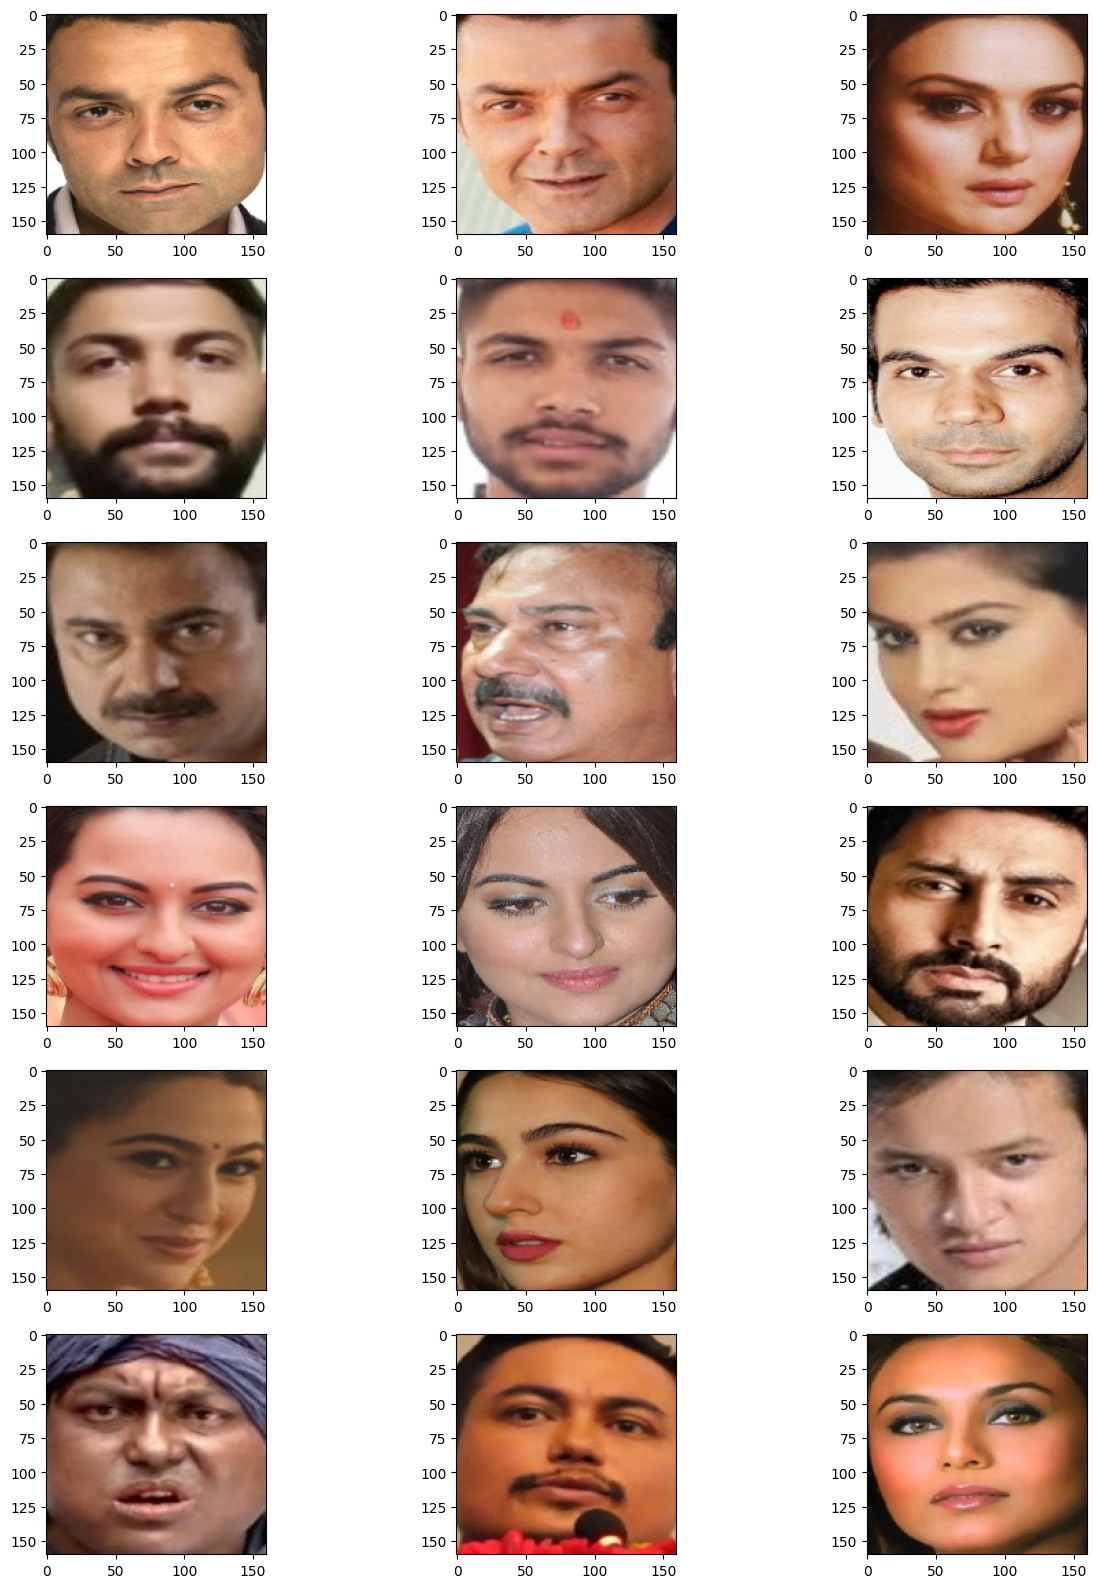

In [36]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

Facenet Encoding

In [37]:
def get_encoder(input_shape):
    """Returns the optimized image encoding model"""
    
    # Load FaceNet model
    facenet_model = FaceNet()
    
    # Set all layers to non-trainable
    for layer in facenet_model.model.layers:
        layer.trainable = False
    
    # Retrieve the output tensor of the model
    output_tensor = facenet_model.model.layers[-1].output

    # Flatten the output tensor
    x = Flatten()(output_tensor)
    
    # Add a dense layer with 256 units and ReLU activation
    x = Dense(256, activation='relu')(x)
    
    # Add BatchNormalization layer
    x = BatchNormalization()(x)
    
    # Add L2 normalization
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    
    # Add a dense layer with 128 units and ReLU activation
    x = Dense(128, activation='relu')(x)
    
    # Add BatchNormalization layer
    x = BatchNormalization()(x)
    
    # # Add L2 normalization
    output = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

    # Define the input and output of the model
    encode_model = Model(inputs=facenet_model.model.input, outputs=output)
    
    return encode_model

In [38]:
encoder=get_encoder((160,160,3))

In [39]:
anchor_input   = layers.Input((160,160,3), name="Anchor_Input")
encoded_a = encoder(anchor_input)

In [40]:
encoded_a

<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'model')>

In [41]:
get_encoder((160,160,3)).summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, None, None,   96         ['Conv2d_1a_3x3[0][0]']          
 Normalization)                 32)                                                         

Siamese Network

In [42]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (160, 160, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 160, 160, 3  0           []                               
                                )]                                                  

In [43]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [44]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [45]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

Training The Model

In [46]:
def test_on_triplets(batch_size = 64):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [47]:
save_all = False
epochs = 20
batch_size= 64

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for x in get_batch(train_triplet, batch_size=batch_size,preprocess=False):
        loss = siamese_model.train_on_batch(x)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 31 sec)
Loss on train    = 0.98605
1/1 [==============================] - 5s 5s/step
Accuracy on test = 1.00000

EPOCH: 2 	 (Epoch done in 8 sec)
Loss on train    = 0.98605
1/1 [==============================] - 0s 90ms/step
Accuracy on test = 1.00000

EPOCH: 3 	 (Epoch done in 8 sec)
Loss on train    = 0.98605
1/1 [==============================] - 0s 74ms/step
Accuracy on test = 1.00000

EPOCH: 4 	 (Epoch done in 8 sec)
Loss on train    = 0.98605
1/1 [==============================] - 0s 75ms/step
Accuracy on test = 1.00000

EPOCH: 5 	 (Epoch done in 8 sec)
Loss on train    = 0.98605
1/1 [==============================] - 0s 83ms/step
Accuracy on test = 1.00000

EPOCH: 6 	 (Epoch done in 8 sec)
Loss on train    = 0.98605
1/1 [==============================] - 0s 76ms/step
Accuracy on test = 1.00000

EPOCH: 7 	 (Epoch done in 8 sec)
Loss on train    = 0.98605
1/1 [==============================] - 0s 74ms/step
Accuracy on test = 1.00000

EPOCH: 8 	 (Epoch do

Evaluating the Model

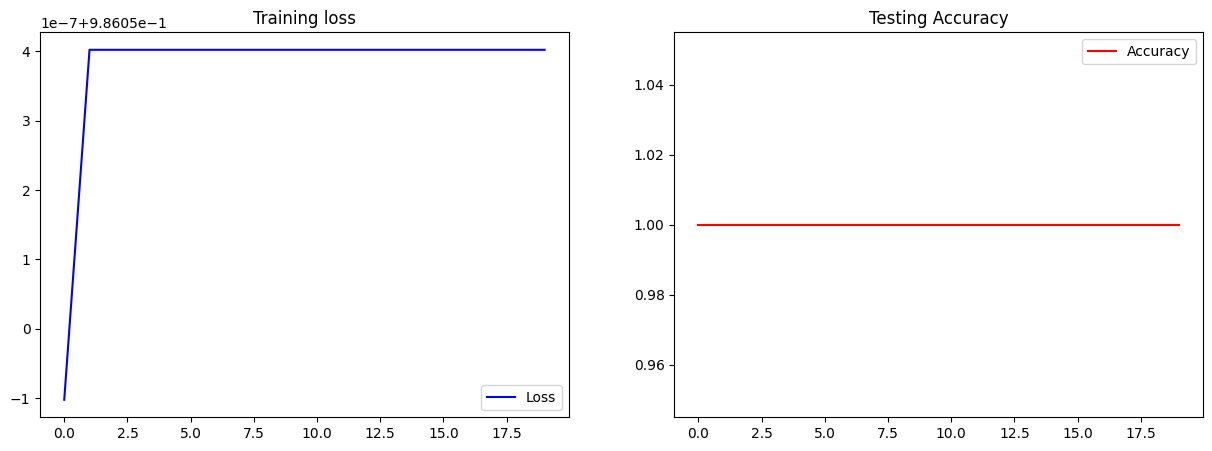

<Figure size 1500x500 with 0 Axes>

In [48]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[0:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # # Comparing the Means over epochs
    # plt.subplot(121)
    # plt.plot(ap_mean, 'b', label='AP Mean')
    # plt.plot(an_mean, 'g', label='AN Mean')
    # plt.title('Means Comparision')
    # plt.legend()
    
    # # Plotting the accuracy
    # ap_75quartile = (ap_mean+ap_stds)
    # an_75quartile = (an_mean-an_stds)
    # plt.subplot(122)
    # plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    # plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    # plt.title('75th Quartile Comparision')
    # plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

Using the Model

In [49]:
def extract_encoder(model):
    encoder = get_encoder((160, 160, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, None, None,   864         ['input_5[0][0]']                
                                32)                                                               
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, None, None,   96         ['Conv2d_1a_3x3[0][0]']          
 Normalization)                 32)                                                         

Classify Images

In [50]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

2/2 [==============================] - 0s 46ms/step

Accuracy of model: 0.9453125



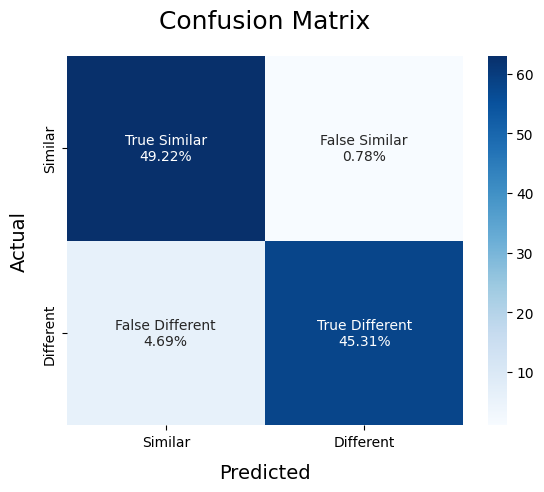

In [51]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2  in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=64):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)